# Currecy Exchange Rate Recommendation System

# **Importing Libraries**

In [ ]:
# !pip install yfinance scikit-learn tensorflow
# !pip install plotly

import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
import plotly.graph_objects as go
import seaborn as sns
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor

# **Data Loading**

In [ ]:
base_currency = 'PKR'
target_currency = 'USD'
df = yf.download(f"{target_currency}{base_currency}=X", start="2013-12-20", end="2023-12-20")
df.reset_index(inplace=True)
print("Data collected successfully:")
print(df.head())
print(df.tail())

[*********************100%%**********************]  1 of 1 completed

Data collected successfully:
        Date        Open        High         Low       Close   Adj Close  \
0 2013-12-20  105.500000  106.199997  104.970001  106.199997  106.199997   
1 2013-12-23  104.790001  106.099998  104.699997  104.830002  104.830002   
2 2013-12-24  104.639999  106.150002  103.930000  106.150002  106.150002   
3 2013-12-25  104.639999  106.150002  103.930000  106.150002  106.150002   
4 2013-12-26  103.830002  106.150002  103.830002  106.150002  106.150002   

   Volume  
0       0  
1       0  
2       0  
3       0  
4       0  
           Date        Open        High         Low       Close   Adj Close  \
2600 2023-12-13  282.249054  282.249054  282.137268  282.175873  282.175873   
2601 2023-12-14  279.199738  283.299988  278.443207  283.299988  283.299988   
2602 2023-12-15  277.142853  283.000000  277.142853  283.000000  283.000000   
2603 2023-12-18  280.193359  280.193359  278.257080  279.846649  279.846649   
2604 2023-12-19  278.134735  283.000000  277.54

In [ ]:
# Specify the path where you want to save the CSV file
csv_file_path = 'currency_data.csv'

# Write the DataFrame to a CSV file
df.to_csv(csv_file_path, index=False)

In [ ]:
csv_file_path = 'currency_data.csv'

df = pd.read_csv(csv_file_path)
df.head()
df.tail()

Description of dataset

In [ ]:
# Creating a dictionary to store the dataset description
dataset_description = {
    "Size": df.shape,
    "Attributes": df.dtypes.to_dict(),
    "Target Class Definition": "The 'Close' value, representing the exchange rate of PKR to USD.",
    "Independent Variables Data Types": {col: str(dtype) for col, dtype in df.drop('Close', axis=1).dtypes.items()},
    "Dependent Variable Data Type": ('Close', str(df['Close'].dtype)),
    "Type of Prediction": "Regression (forecasting a continuous value - the exchange rate)"
}

# Displaying the dataset description
for key, value in dataset_description.items():
    print(f"{key}: {value}")

Size: (2605, 7)
Attributes: {'Date': dtype('<M8[ns]'), 'Open': dtype('float64'), 'High': dtype('float64'), 'Low': dtype('float64'), 'Close': dtype('float64'), 'Adj Close': dtype('float64'), 'Volume': dtype('int64')}
Target Class Definition: The 'Close' value, representing the exchange rate of PKR to USD.
Independent Variables Data Types: {'Date': 'datetime64[ns]', 'Open': 'float64', 'High': 'float64', 'Low': 'float64', 'Adj Close': 'float64', 'Volume': 'int64'}
Dependent Variable Data Type: ('Close', 'float64')
Type of Prediction: Regression (forecasting a continuous value - the exchange rate)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2605 entries, 0 to 2604
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2605 non-null   datetime64[ns]
 1   Open       2605 non-null   float64       
 2   High       2605 non-null   float64       
 3   Low        2605 non-null   float64       
 4   Close      2605 non-null   float64       
 5   Adj Close  2605 non-null   float64       
 6   Volume     2605 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 142.6 KB


# **Data Preprocessing**

In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2605.000000,2605.000000,2605.000000,2605.000000,2605.000000,2605.0
mean,147.485525,148.671692,147.066497,148.150498,148.150498,0.0
std,54.656784,54.901574,54.411262,54.879545,54.879545,0.0
min,94.936996,95.357002,4.000000,2.000000,2.000000,0.0
25%,103.309998,104.599998,103.230003,103.769997,103.769997,0.0
50%,138.029999,139.149994,137.669998,138.250000,138.250000,0.0
75%,165.435013,166.250000,164.986298,166.050003,166.050003,0.0
max,306.677795,307.000000,305.982147,307.000000,307.000000,0.0


### 1.  Handling Missing Values



In [ ]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### 2.   Converting date strings to Python datetime objects for easier manipulation.

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

#### 3. Filling Missing Values

>  Using Forward Fill (ffill) in Pandas DataFrame

In [ ]:
df.fillna(method='ffill', inplace=True)

# Exploratory Data Analysis

1. Visualization of Distributions

In [ ]:
# Candlestick chart with Volume
fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Market Data')])

# Adding Volume as bar chart
fig.add_trace(go.Bar(x=df['Date'], y=df['Volume'], name='Volume', marker_color='blue', yaxis='y2'))

# Create layout with secondary y-axis for the volume
fig.update_layout(
    title='Candlestick Chart of PKR to USD with Volume',
    xaxis_title='Date',
    yaxis_title='Exchange Rate',
    yaxis=dict(
        title='Exchange Rate',
        side='left'
    ),
    yaxis2=dict(
        title='Volume',
        overlaying='y',
        side='right',
        showgrid=False
    )
)

fig.show()

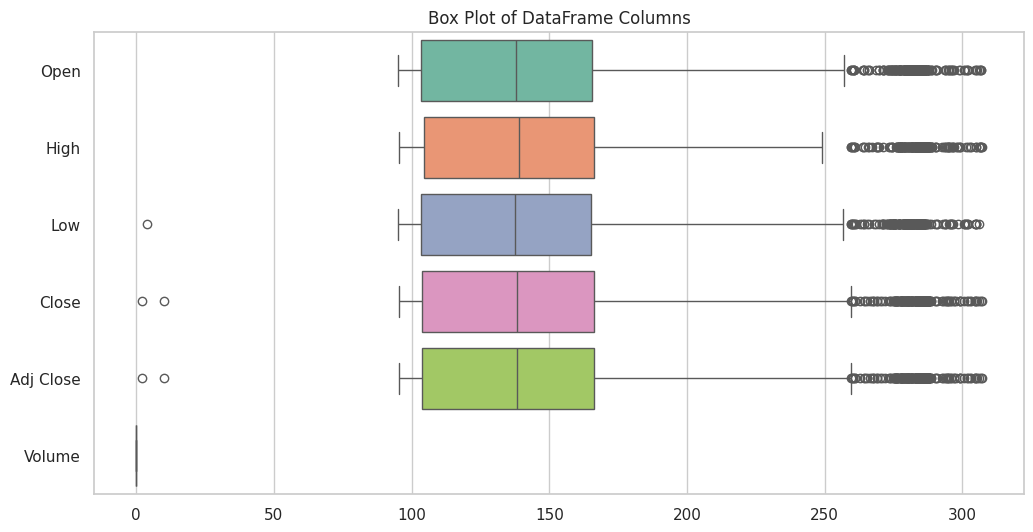

In [ ]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Plot 1: Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, orient="h", palette="Set2")
plt.title("Box Plot of DataFrame Columns")
plt.xticks()
plt.show()

Explanation for Removing `Volume` Column

> From the box plot, it seems that the 'Volume' column contains only zeros. Since a box plot visualizes the distribution of data based on a five-number summary (minimum, first quartile, median, third quartile, and maximum), a column with a single constant value (like zero in this case) would not provide any meaningful variation or distribution to analyze.
Therefore, in the context of data analysis, the 'Volume' column is unnecessary as it does not contribute any information about variability or spread in the data. This pattern holds throughout the entire dataset, so the 'Volume' column could be considered for removal from the dataset before conducting further analysis.



In [ ]:
df.drop(columns=['Volume'], inplace=True)
df.head()

,Date,Open,High,Low,Close,Adj Close
0,2013-12-20,105.500000,106.199997,104.970001,106.199997,106.199997
1,2013-12-23,104.790001,106.099998,104.699997,104.830002,104.830002
2,2013-12-24,104.639999,106.150002,103.930000,106.150002,106.150002
3,2013-12-25,104.639999,106.150002,103.930000,106.150002,106.150002
4,2013-12-26,103.830002,106.150002,103.830002,106.150002,106.150002


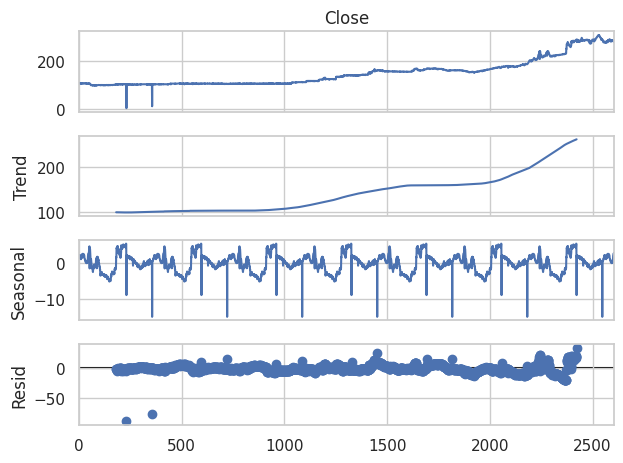

In [ ]:
# Seasonality and Trend Decomposition
import statsmodels.api as sm
# Assuming your data is daily and you have at least two years of data
try:
    decomposition = sm.tsa.seasonal_decompose(df['Close'], model='additive', period=365)
    fig = decomposition.plot()
    plt.show()
except ValueError as e:
    # Fallback to a smaller period if there aren't enough data points for a yearly cycle
    print(e)
    print("Trying with a smaller period...")
    # Here we attempt to find the largest divisor of the data points
    # length to use as a period
    df_length = len(df['Close'])
    for period in range(df_length//2, 1, -1):
        if df_length % period == 0:
            decomposition = sm.tsa.seasonal_decompose(df['Close'],
                  model='additive', period=period)
            fig = decomposition.plot()
            plt.show()
            break

# **Feature Engineering**

### 1. Lag Features:
> Lag features are past values of a variable as new features. This will be particularly useful in time series forecasting.


In [ ]:
for lag in [1, 7]:  # for 1-day and 7-day lags
    df[f'lag_{lag}'] = df['Close'].shift(lag)

### 2. Technical Indicators:

2.1. Simple Moving Average (SMA)

2.2. Relative Strength Index (RSI), etc.


      

In [ ]:
# 2.1 - SMA
for sma in [7, 30]:  # for 7-day and 30-day SMAs
    df[f'{sma}_day_avg'] = df['Close'].rolling(window=sma).mean()


# 2.2 - RSI
def compute_RSI(data, window):
    diff = data.diff(1).dropna()
    gain = 0 * diff
    loss = 0 * diff
    gain[diff > 0] = diff[diff > 0]
    loss[diff < 0] = -diff[diff < 0]
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi
df['RSI'] = compute_RSI(df['Close'], 14)  # RSI computation function FOR 14

In [ ]:
df.dropna(inplace=True)
df.head()

,Date,Open,High,Low,Close,Adj Close,lag_1,lag_7,7_day_avg,30_day_avg,RSI
29,2014-01-30,104.230003,104.250000,104.230003,105.339996,105.339996,105.349998,104.290001,105.245714,105.296334,49.017178
30,2014-01-31,104.620003,105.419998,104.239998,105.419998,105.419998,105.339996,105.400002,105.248571,105.270334,63.494467
31,2014-02-03,104.739998,105.470001,104.339996,104.730003,104.730003,105.419998,105.300003,105.167143,105.267001,42.175595
32,2014-02-04,104.209999,105.410004,104.209999,105.410004,105.410004,104.730003,105.300003,105.182857,105.242334,46.560860
33,2014-02-05,104.209999,104.290001,104.070000,105.300003,105.300003,105.410004,104.629997,105.278572,105.214001,50.000000


### 3. Preparing Data for Feature Selection

In [ ]:
features = ['Open', 'High', 'Low', 'lag_1', 'lag_7', '7_day_avg', '30_day_avg', 'RSI']
target = 'Close'

In [ ]:
skewness = df[features].skew()
skewness

Open          1.260299
High          1.264073
Low           1.248543
lag_1         1.247487
lag_7         1.258276
7_day_avg     1.262278
30_day_avg    1.276804
RSI           0.268795
dtype: float64

A skewness value between −1 and +1 is considered excellent, but a value between −2 and +2 is generally considered acceptable. Values beyond −2 and +2 are considered indicative of substantial nonnormality.

Source: [How to Interpret Excess Kurtosis and Skewness](https://www.smartpls.com/documentation/functionalities/excess-kurtosis-and-skewness#:~:text=As%20a%20general%20guideline%2C%20a,66)

Normalization to handle outliers:

In [ ]:
from scipy.stats import skew

# Columns to be normalized, excluding 'Close' and 'Date'
columns_to_normalize = df.columns.drop(['Close', 'Date'])

# Function to identify and handle outliers using IQR
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Capping the outliers
    df[column] = df[column].clip(lower_bound, upper_bound)

# Applying outlier handling to each column
for col in columns_to_normalize:
    handle_outliers(df, col)

# Checking skewness after handling outliers
skewness_after_outliers = df[columns_to_normalize].apply(skew)

# Applying transformations to reduce skewness
for col in columns_to_normalize:
    if abs(skewness_after_outliers[col]) > 0.5:
        # Apply log transformation to reduce skewness
        df[col] = df[col].apply(lambda x: np.log(x + 1) if x > 0 else x)

# Checking the skewness after transformations
final_skewness = df[columns_to_normalize].apply(skew)
final_skewness

Open          0.603140
High          0.593608
Low           0.384619
Adj Close     0.181910
lag_1         0.182801
lag_7         0.190201
7_day_avg     0.594113
30_day_avg    0.602733
RSI           0.262813
dtype: float64

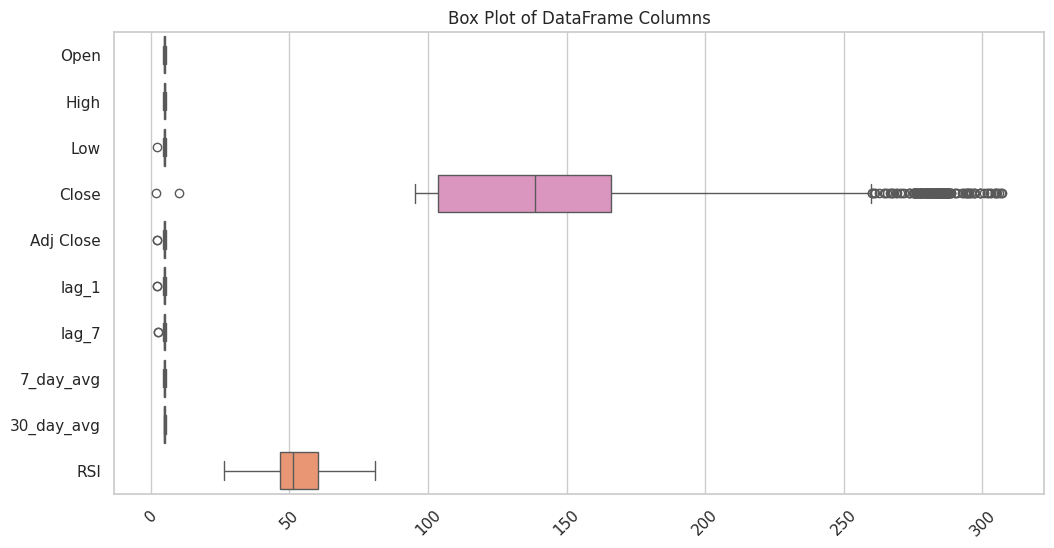

In [ ]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Plot 1: Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, orient="h", palette="Set2")
plt.title("Box Plot of DataFrame Columns")
plt.xticks(rotation=45)
plt.show()

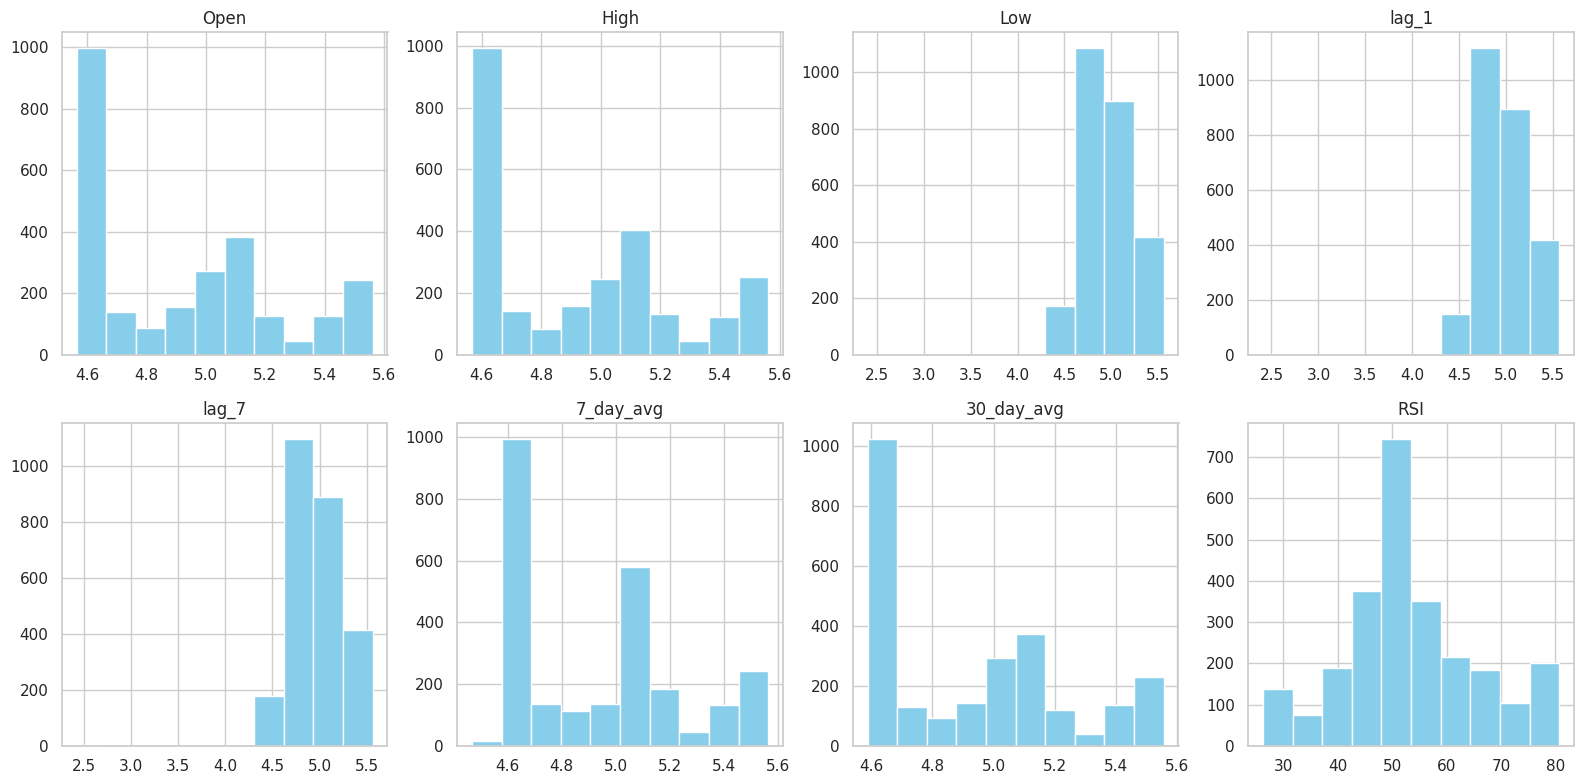

In [ ]:
# Define colors for each feature histogram
colors = ['skyblue']  # One color for each feature

# Calculate the number of rows and columns for the layout
n_features = len(features)
n_cols = 4
n_rows = n_features // n_cols + (n_features % n_cols > 0)

# Set the figsize to ensure each subplot is square-shaped
subplot_size = 4
figsize = (n_cols * subplot_size, n_rows * subplot_size)

# Plot histograms for the selected features
df[features].hist(bins=10, color=colors, layout=(n_rows, n_cols), figsize=figsize)

plt.tight_layout()
plt.show()

### 4. Feature Selection
To enhance the model's performance and ensure we're using the most relevant features, we'll apply two common feature selection methods:

1. Correlation Matrix Analysis
2. Recursive Feature Elimination (RFE) with a Random Forest Regressor

### 4.1. Correlation Matrix Analysis
> This method involves analyzing the correlation matrix of the features and the target variable. Features that have little to no correlation with the target variable can be considered for removal.

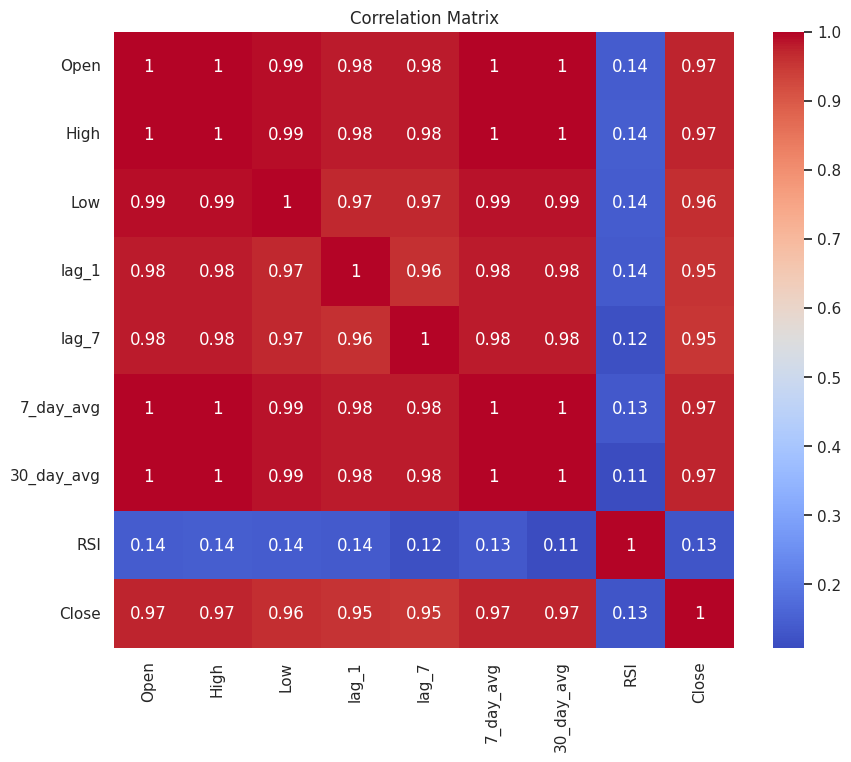

In [ ]:
corr_matrix = df[features + [target]].corr()

# Plotting the Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [ ]:
corr_with_target = corr_matrix[target].drop(target)
# Drop the correlation of the target with itself
print(corr_with_target)

Open          0.974151
High          0.973276
Low           0.964078
lag_1         0.954780
lag_7         0.954330
7_day_avg     0.973919
30_day_avg    0.973382
RSI           0.126544
Name: Close, dtype: float64


### 4.2. Recursive Feature Elimination (RFE) with a Random Forest Regressor
> RFE works by recursively removing the least important features (based on feature importances provided by the model) and building the model with the remaining features. This process continues until the specified number of features is reached.

In [ ]:
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Feature Selection with RFE
model = RandomForestRegressor()
rfe = RFE(model, n_features_to_select=3)  # Choosing to select top 3 features
rfe.fit(X_train, y_train)

features_to_select_from = pd.DataFrame({'Feature':list(X_train.columns), 'Ranking':rfe.ranking_})
print(features_to_select_from.sort_values(by='Ranking'))

      Feature  Ranking
1        High        1
5   7_day_avg        1
6  30_day_avg        1
3       lag_1        2
0        Open        3
2         Low        4
4       lag_7        5
7         RSI        6


## 5. Visualisation

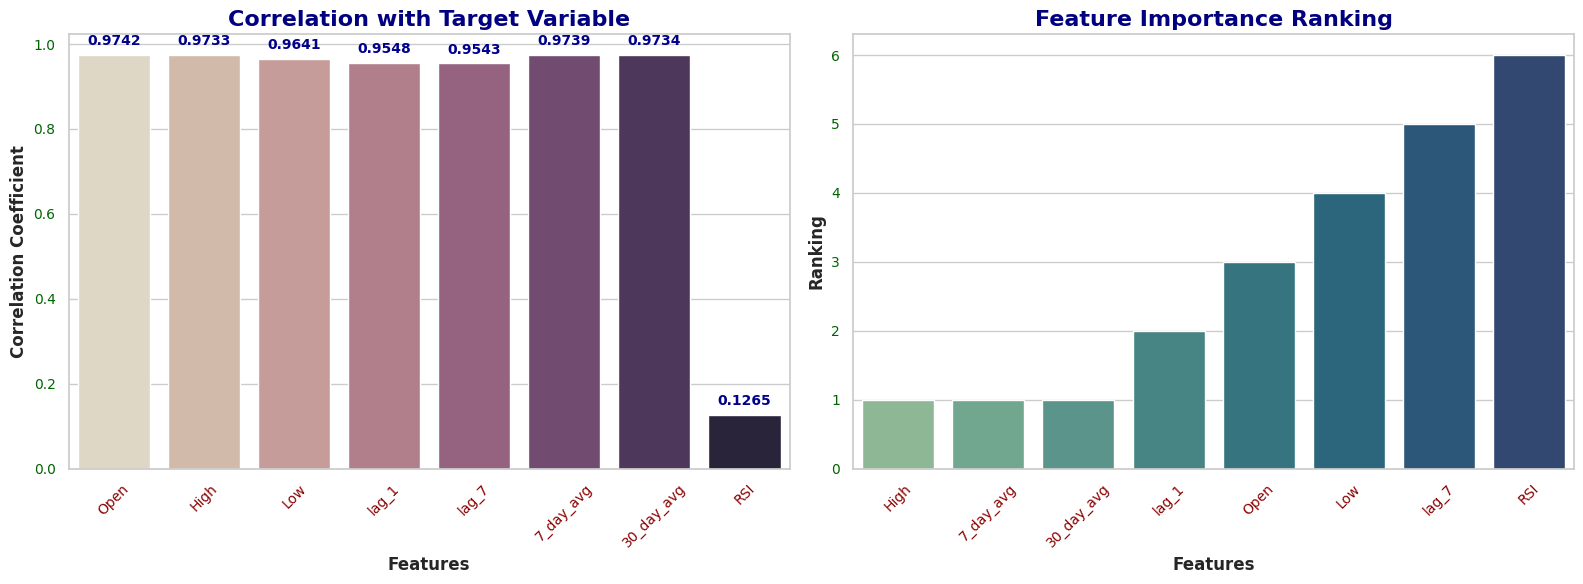

In [ ]:
# Creating a figure with two subplots
plt.figure(figsize=(16, 6))

# First subplot
ax1 = plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
sns.barplot(x=corr_with_target.index, y=corr_with_target.values, palette="ch:s=-.2,r=.6", ax=ax1)

# Settings for the first plot
ax1.set_title('Correlation with Target Variable', fontsize=16, fontweight='bold', color='navy')
ax1.set_xlabel('Features', fontsize=12, fontweight='bold')
ax1.set_ylabel('Correlation Coefficient', fontsize=12, fontweight='bold')
ax1.tick_params(axis='x', labelsize=10, labelrotation=45, labelcolor='darkred')
ax1.tick_params(axis='y', labelsize=10, labelcolor='darkgreen')

# Adding values on the bars
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.4f'),
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center',
                 xytext=(0, 10),
                 textcoords='offset points',
                 fontsize=10,
                 color='darkblue',
                 fontweight='bold')

# Second subplot
ax2 = plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
sns.barplot(x='Feature', y='Ranking', data=features_to_select_from.sort_values(by='Ranking'), palette="crest", ax=ax2)

# Settings for the second plot
ax2.set_title('Feature Importance Ranking', fontsize=16, fontweight='bold', color='navy')
ax2.set_xlabel('Features', fontsize=12, fontweight='bold')
ax2.set_ylabel('Ranking', fontsize=12, fontweight='bold')
ax2.tick_params(axis='x', labelsize=10, labelrotation=45, labelcolor='darkred')
ax2.tick_params(axis='y', labelsize=10, labelcolor='darkgreen')

# Display the plots
plt.tight_layout()  # Adjusts the plots to fit into the figure area.
plt.show()

## 6. Decision on Which Features to Keep

Based on both the correlation matrix and RFE ranking:


1. We will consider 'High' (or 'Open' or 'Low', but not all three due to multicollinearity).
2. Include 'lag_1' to incorporate information from the previous day's close.
3. '7_day_avg' can be a good feature as it is less correlated with 'Open' and represents a short-term trend.
4. We may consider dropping '30_day_avg' because it is somewhat redundant with '7_day_avg' and is ranked lower in RFE.
5. 'RSI' is ranked lowest and has a lower correlation with 'Close', but it represents market momentum and might provide unique insights. It could be worth testing the model with and without 'RSI' to see if it improves the model performance.

In conclusion, we will start with `High`, `lag_1`, `7_day_avg`, and `RSI` for our model and see how it performs. However, we will iterate and try different combinations of features to find the best model.

In [ ]:
features = ['High', 'lag_1', '7_day_avg', 'RSI']
target = 'Close'

**Observation:**

We observed that the inclusion of `RSI` did not enhance the model's performance. This suggests that `RSI`, despite its potential to represent market momentum, may not be as influential in predicting `Close` prices as hypothesized.

Therefore, we will revise our model by excluding `RSI` from the feature set. We will continue to use `High`, `lag_1`, and `7_day_avg`.

In [ ]:
features.remove('RSI')
features

['High', 'lag_1', '7_day_avg']

# Model Training and Evaluation

1.   **Linear Regression**:
  *   *When to use*: Use when you want to model linear relationships between input features and the target variable.
  *   *Why to use*: It's simple, interpretable, and works well for problems where the relationship between variables is approximately linear.


2.   **Random Forest:**
  *   *When to use*: Use for both regression and classification tasks when you want a robust, versatile model.
  *   *Why to use*: It's an ensemble of decision trees that handles complex relationships, outliers, and high-dimensional data. It's suitable for a wide range of problems and is less prone to overfitting.


3.   **Gradient Boosting:**
  *   *When to use*: Use when you need high predictive accuracy and want to improve the performance of decision trees.
  *   *Why to use*: Gradient Boosting builds an ensemble of decision trees sequentially, reducing errors at each step. It's powerful and often one of the top-performing algorithms in machine learning competitions.


4.   **XGBoost:**
  *   *When to use*: Use when you want a highly optimized and efficient implementation of gradient boosting.
  *   *Why to use*: XGBoost is known for its speed and performance. It's often the go-to choice for gradient boosting due to its optimization techniques and scalability.

In [ ]:
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(
        n_estimators=100, # A moderate number like 100 strikes a balance between model accuracy and training time.
        random_state=42 # Ensures that the results are reproducible i.e., we will get the same results each time we run the model with the same data.
    ),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

# Training and Evaluation
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    results[name] = {'MSE': mse, 'R2': r2}
    print(f"{name} - MSE: {mse}, R2: {r2}")

Linear Regression - MSE: 161.4397832817465, R2: 0.9491317042800269
Random Forest - MSE: 10.483045048961904, R2: 0.9966968821144553
Gradient Boosting - MSE: 14.038463862129822, R2: 0.9955766000382527
XGBoost - MSE: 28.111033515911934, R2: 0.9911424536330931


In [ ]:
# Determine the best model based on MSE and R2
best_model_name = min(results, key=lambda x: (results[x]['MSE'], -results[x]['R2']))
print(f"Best Model: {best_model_name} with MSE: {results[best_model_name]['MSE']} and R2: {results[best_model_name]['R2']}")

Best Model: Random Forest with MSE: 10.483045048961904 and R2: 0.9966968821144553


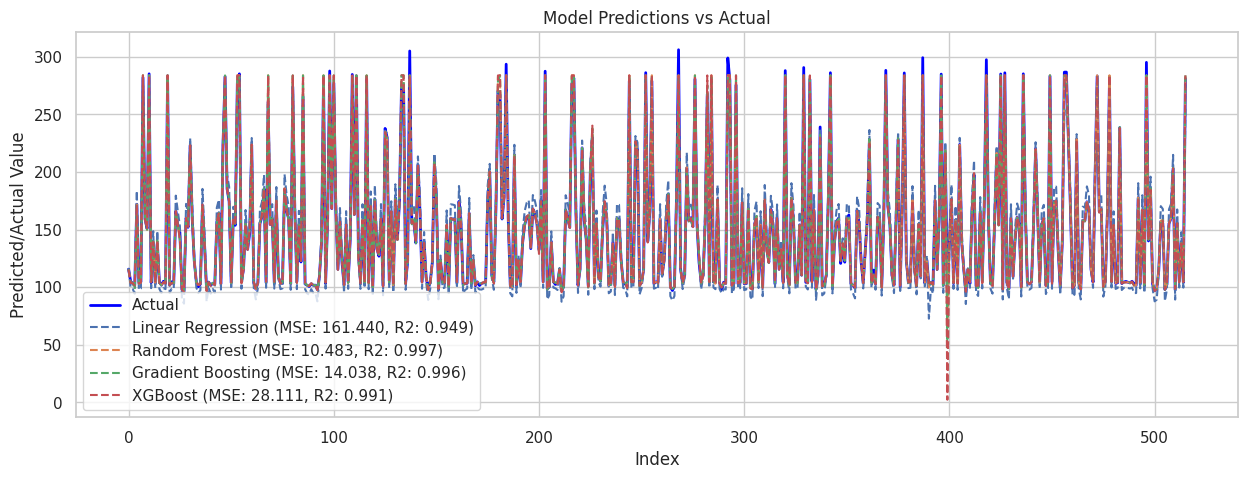

In [ ]:
# Visualization of Predictions
plt.figure(figsize=(15, 5))
plt.plot(y_test.reset_index(drop=True), label='Actual', color='blue', linewidth=2)

for name, model in models.items():
    predictions = model.predict(X_test)
    plt.plot(predictions, label=f"{name} (MSE: {results[name]['MSE']:.3f}, R2: {results[name]['R2']:.3f})", linestyle='--')

plt.title('Model Predictions vs Actual')
plt.xlabel('Index')
plt.ylabel('Predicted/Actual Value')
plt.legend()
plt.show()

# Recommendation

In [ ]:
# Decision recommendation based on the best model's predictions
def recommend_decision(predictions, current_price):
    future_price = np.mean(predictions)
    if future_price > current_price:
        return "Buy"
    else:
        return "Sell"

current_price = df['Close'].iloc[-1]
best_model = models[best_model_name]
future_predictions = best_model.predict(X_test)
decision = recommend_decision(future_predictions, current_price)
print(f"Recommended action: {decision} it now!")

Recommended action: Sell it now!


# Forecasting Next Week

Predictions for the next week:
Day 1: 283.96408200260817
Day 2: 258.4263948375967
Day 3: 282.7535076052639
Day 4: 283.96408200260817
Day 5: 283.96408200260817
Day 6: 283.96408200260817
Day 7: 283.96408200260817


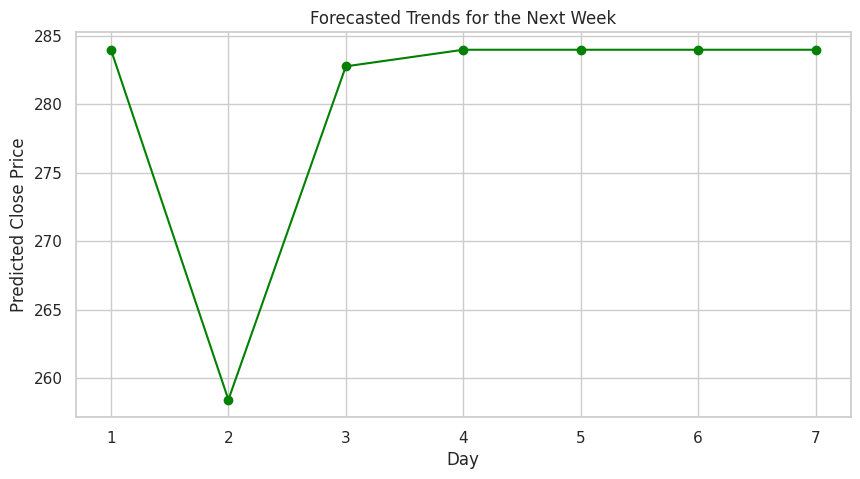

In [ ]:
def forecast_next_week(model, recent_data, n_days=7):
    """
    Forecast the next week's trend using the provided model.
    Assumes recent_data is a DataFrame with the same features used for training the model.

    :param model: Trained model for prediction.
    :param recent_data: DataFrame containing the most recent data points.
    :param n_days: Number of days to predict.
    :return: Array of predictions.
    """
    predictions = []
    current_data = recent_data.copy()
    for _ in range(n_days):
        next_prediction = model.predict(current_data[-1:].values)[0]
        predictions.append(next_prediction)
        # Shift the data and append the new prediction for multi-step forecasting
        next_row = current_data.iloc[-1:].shift(1, axis=1)
        next_row[features[0]] = next_prediction
        current_data = current_data.append(next_row, ignore_index=True)
    return predictions

# Best model from previous evaluation
best_model = models[best_model_name]

# Prepare recent data for prediction
recent_data = df[features].tail(10)

# Forecast for the next week
next_week_predictions = forecast_next_week(best_model, recent_data)

# Print predictions
print("Predictions for the next week:")
for i, pred in enumerate(next_week_predictions, 1):
    print(f"Day {i}: {pred}")

# Visualization of Predictions for the Next Week
plt.figure(figsize=(10, 5))
plt.plot(range(1, 8), next_week_predictions, marker='o', linestyle='-', color='green')
plt.title('Forecasted Trends for the Next Week')
plt.xlabel('Day')
plt.ylabel('Predicted Close Price')
plt.xticks(range(1, 8))
plt.grid(True)
plt.show()

In [ ]:
# Get the last date from the existing data
last_date = df['Date'].iloc[-1]

# Generate dates for the next week
next_dates = pd.date_range(start=last_date, periods=len(next_week_predictions) + 1, closed='right', freq='B')

# Create a DataFrame for the predictions
predictions_df = pd.DataFrame({
    'Date': next_dates,
    'Predicted_Close': next_week_predictions
})

# Append the predictions to the original DataFrame
# Note: The 'Close' column will be NaN for the prediction rows
extended_data = pd.concat([df, predictions_df], ignore_index=True)
extended_data

,Date,Open,High,Low,Close,Adj Close,lag_1,lag_7,7_day_avg,30_day_avg,RSI,Predicted_Close
0,2014-01-30,4.656148,4.656338,4.656148,105.339996,4.666641,4.666736,4.656718,4.665754,4.666231,49.017178,NaN
1,2014-01-31,4.659848,4.667394,4.656243,105.419998,4.667394,4.666641,4.667206,4.665781,4.665986,63.494467,NaN
2,2014-02-03,4.660983,4.667863,4.657193,104.730003,4.660889,4.667394,4.666265,4.665015,4.665955,42.175595,NaN
3,2014-02-04,4.655958,4.667300,4.655958,105.410004,4.667300,4.660889,4.666265,4.665163,4.665723,46.560860,NaN
4,2014-02-05,4.655958,4.656718,4.654627,105.300003,4.666265,4.667300,4.659942,4.666064,4.665456,50.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2578,2023-12-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,282.753508
2579,2023-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,283.964082
2580,2023-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,283.964082
2581,2023-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,283.964082


In [ ]:
# Create a column to distinguish between historical and predicted data
extended_data['Type'] = 'Historical'
extended_data.loc[extended_data['Predicted_Close'].notna(), 'Type'] = 'Predicted'

# Combine 'Close' and 'Predicted_Close' into a single column for plotting
extended_data['Value'] = extended_data['Close'].fillna(extended_data['Predicted_Close'])

# Create the interactive plot
fig = px.line(
    extended_data,
    x='Date',
    y='Value',
    color='Type',
    hover_data={'Date': '|%B %d, %Y', 'Value': True, 'Type': False}
)

# Customize hover template to show Date and Value
fig.update_traces(hovertemplate='Date: %{x}<br>Value: %{y:.2f}')

# Show the figure
fig.show()
